### Introduction

This notebook is for finding the optimal $p_w, p_h$ priors given a file of annotations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob
import json

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Build Data

A dataset of $[p_w, p_h]$ pairs of all bbox annotations.

In [2]:
# paths to all annotation files

annotation_paths = '/Users/falkosky/Downloads/data_1/simplified_annotations/annotations/*'
annotation_paths = glob.glob(annotation_paths)

In [3]:
# functions for extraction pwph from all annotations

def path_to_text(path):
    with open(path, 'r') as file:
        text = file.read()
        return text

def text_to_numpy(text):
    list_of_str_nums = text.rsplit()
    array = np.array(list_of_str_nums, dtype=np.float32)
    array = array.reshape([-1, 5])
    return array

def numpy_to_pwph_list(array):
    pwph_list = array[:, 3:].tolist()
    return pwph_list

def path_to_pwph_list(path):
    text      = path_to_text(path)
    array     = text_to_numpy(text)
    pwph_list = numpy_to_pwph_list(array)
    return pwph_list

In [4]:
# extract all pwph from annotations

pwph = []

for path in annotation_paths:
    pwph_list = path_to_pwph_list(path)
    pwph.extend(pwph_list)

pwph = np.array(pwph)
pd.DataFrame(pwph, columns=['$p_w$', '$p_h$'])

,$p_w$,$p_h$
0,0.115625,0.083333
1,0.097917,0.078704
2,0.101042,0.085185
3,0.109375,0.078704
4,0.119792,0.087037
...,...,...
4313,0.086979,0.065741
4314,0.150521,0.098148
4315,0.101042,0.149074
4316,0.166146,0.110185


### Calculations

Convert array `pwph` to `pwph_log` by taking the element wise $\log$. (Avoids large box bias)


In [5]:
# calc
pwph_log = np.log(pwph)

### Finding optimal clusters

Using KMeans and clustering with various cluster sizes, optimal points will be found.

In [6]:
# calculate silhouette scores for n_cluster sizes {2,3,4,5,6,7,8,9}
silhouette_scores = []

for n_clusters in range(2, 10):
    kmeans = KMeans(n_clusters, random_state=2)
    kmeans.fit(pwph_log)
    score = silhouette_score(pwph_log, kmeans.labels_)
    silhouette_scores.append(score)

silhouette_scores = np.array(silhouette_scores)

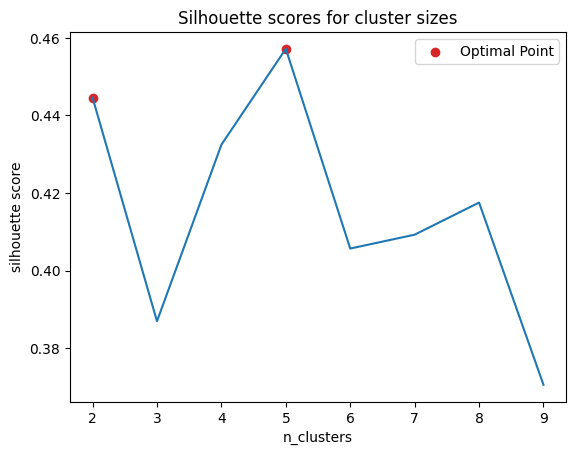

In [7]:
# plot results
plt.title("Silhouette scores for cluster sizes")
plt.xlabel('n_clusters')
plt.ylabel('silhouette score')
plt.plot(range(2, 10), silhouette_scores)
plt.scatter(np.array(range(2, 10))[[0,3]], silhouette_scores[[0,3]], color='C3', label='Optimal Point')
plt.legend()
plt.show()

### Visualization of Cluster Options

Plotting `pwph` colored by cluster.

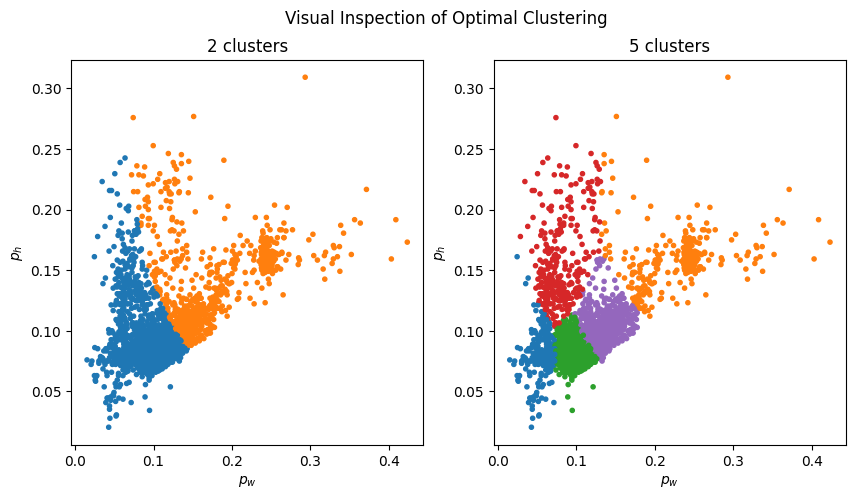

In [8]:
plt.figure(figsize=(10, 5))

kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(pwph_log)
colors = [f"C{label}" for label in kmeans.labels_]
plt.subplot(1, 2, 1)
plt.scatter(pwph[:, 0], pwph[:, 1], marker='.', c=colors)
plt.title('2 clusters')
plt.xlabel('$p_w$')
plt.ylabel('$p_h$')

kmeans = KMeans(n_clusters=5, random_state=2)
kmeans.fit(pwph_log)
colors = [f"C{label}" for label in kmeans.labels_]
plt.subplot(1, 2, 2)
plt.scatter(pwph[:, 0], pwph[:, 1], marker='.', c=colors)
plt.title('5 clusters')
plt.xlabel('$p_w$')
plt.ylabel('$p_h$')


plt.suptitle('Visual Inspection of Optimal Clustering')
plt.show()

### Conclusion

Both n_clusters {2, 5} seem viable and should be tested in the final model.

In [9]:
kmeans = KMeans(n_clusters=2, random_state=2)
kmeans.fit(pwph_log)
clusters_2_log = kmeans.cluster_centers_

# convert back to original space!
clusters_2     = np.exp(clusters_2_log)

kmeans = KMeans(n_clusters=5, random_state=2)
kmeans.fit(pwph_log)
clusters_5_log = kmeans.cluster_centers_

# convert back to original space!
clusters_5     = np.exp(clusters_5_log)

cluster_centers = {'2':clusters_2.tolist(), '5':clusters_5.tolist()}

In [10]:
# with open('cluster_centers.json', 'w') as file:
#     json.dump(cluster_centers, file)